# Advance Lane Finding project


### **Importing the requirements  the project**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
import cv2
import glob
import pickle
import os.path

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### **Computing the camera caliberation matric with given images**

In [2]:
def caliberate_camera(images):
    """Images input is a list of all the image names for caliberation"""
    
    #prepating a object points
    objp = np.zeros(((9*6),3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    #arrays to store obj and image points for all images
    objpoints = []
    imgpoints = []
    
    chessboard = [] #For the visualization purpose
    
    #looping over the images in list images
    for image in images:
        img = cv2.imread(image) #reading the image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray,(9,6))
        
        if ret == True:  
            objpoints.append(objp)    #If found saving the points to lists
            imgpoints.append(corners)
            
            img = cv2.drawChessboardCorners(gray, (7,6), corners,ret)
            
    if len(imgpoints) > 0:
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        print("Camera caliberation done. Dumping the caliberation parameters to caliberationparameters.pickle")
        
        # Storing the caliberation parameters to use again
        calib = {"ret": ret, "mtx":mtx, "dist":dist,"rvecs":rvecs,"tvecs":tvecs}

        #opening a pikcle file to dump above dictionary
        calibparms = open("caliberationParameters.pickle",'wb')
        
        pickle.dump(calib,calibparms)
        
        calibparms.close()
        
    return ret, mtx, dist, rvecs, tvecs

images = glob.glob("camera_cal/*.jpg")

ret, mtx, dist, rvecs, tvecs = caliberate_camera(images)


Camera caliberation done. Dumping the caliberation parameters to caliberationparameters.pickle


## Distortion correction function

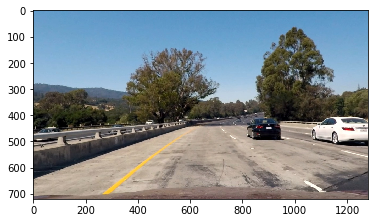

In [3]:
def correct_distortion(img, ret, mtx, dist, rvecs, tvecs ):
    """Input image is an RGB image"""
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread("test_images/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = correct_distortion(img, ret, mtx, dist, rvecs, tvecs )
plt.imshow(img)

## Defining function to visualize two images

In [4]:
def visualize(img1,img2,comment1='Image',comment2='Final',cm='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
    f.tight_layout()
    ax1.imshow(img1,cmap=cm)
    ax1.set_title(comment1, fontsize=30)
    ax2.imshow(img2,cmap=cm)
    ax2.set_title(comment2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# From the lesson **Gradients and Color spaces**
## calculating the thresholds
We shall calculate all the thresholds to obtain a combined image to detect lane lines over it

### calculating the Sobel in x or y directions 
Using the function I solved in the quiz

In [5]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=5 ,thresh_min=30, thresh_max=100,):
    
    """
    Funtion accepts an RGB image and calculates the sobel in the direction specified in orient variable
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    absolute = np.abs(sobel)
    
    binary_output = np.uint8(255*absolute/np.max(absolute))    
        
    sbinary = np.zeros_like(sobel) 
    
    sbinary[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    
    return sbinary

### Sobel in x direction

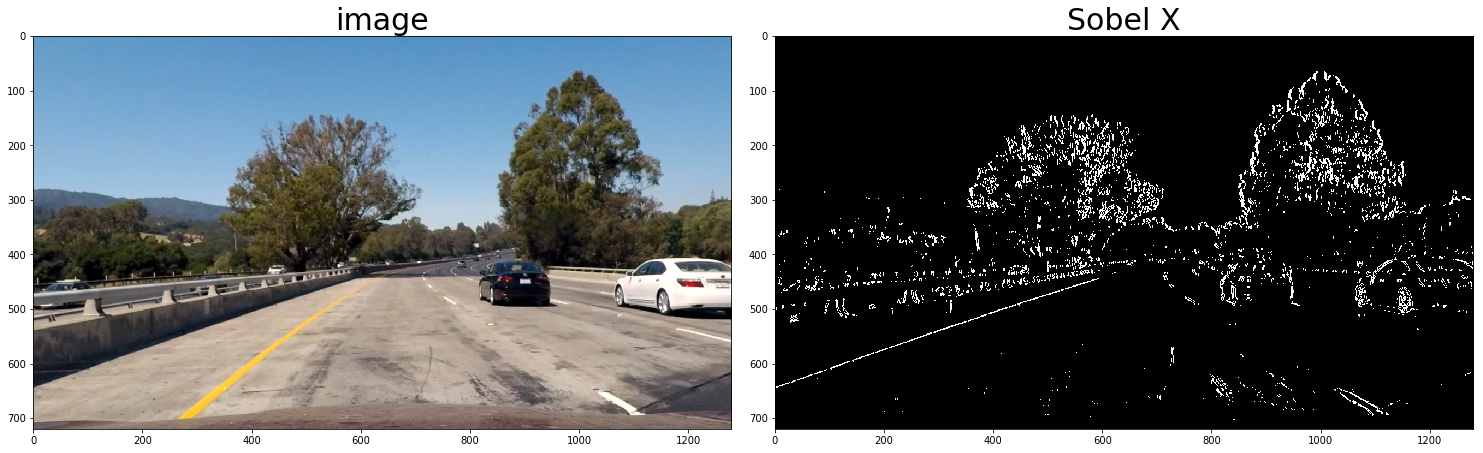

In [6]:
sobel_x = abs_sobel_thresh(img,orient='x')
visualize(img,sobel_x,comment1='image',comment2='Sobel X')

### Sobel in Y direction

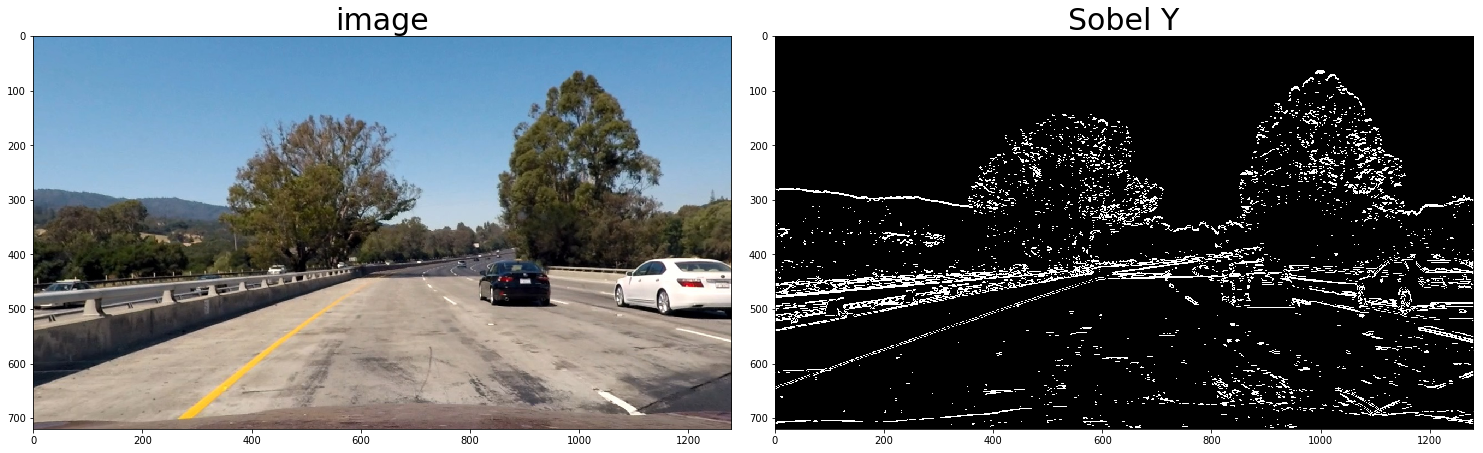

In [7]:
sobel_y = abs_sobel_thresh(img,orient='y')
visualize(img,sobel_y,comment1='image',comment2='Sobel Y')

## Calculating the Magnitude Threshold
Using the Function I solved in the quiz

In [8]:
def mag_thresh(img, sobel_kernel=5, mag_thresh=(30, 255)):
    """
    Accepts an RGB image as input and returns an image with magni
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    magnitude = ((sobelx**2)+(sobely**2))**0.5
    
    absolute = np.abs(magnitude)
    
    binary_output = np.uint8(255*absolute/np.max(absolute))

    sbinary = np.zeros_like(sobelx) 
    
    sbinary[(binary_output >= mag_thresh[0]) & (binary_output <=  mag_thresh[1])] = 1
    
    return sbinary

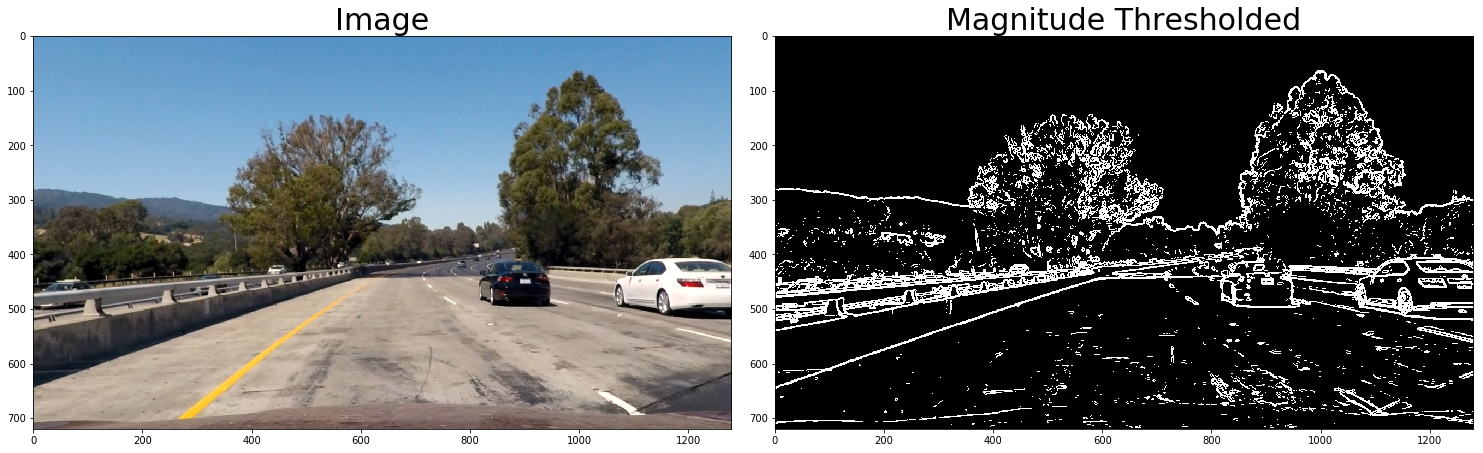

In [9]:
mag_img = mag_thresh(img)
visualize(img, mag_img,comment2='Magnitude Thresholded')

## Directional Gradient
Using the function from the quiz I solved

In [10]:
def dir_threshold(img, sobel_kernel=15, thresh=(0.7,1.3)):
    
    """
    Accepts an RGB image and returns an direction threshold computed image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # magnitude = ((sobelx**2)+(sobely**2))**0.5
    
    direction = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    
    binary_output = np.zeros_like(direction) 
    
    binary_output[(direction >= thresh[0]) & (direction <=  thresh[1])] = 1
    
    return binary_output

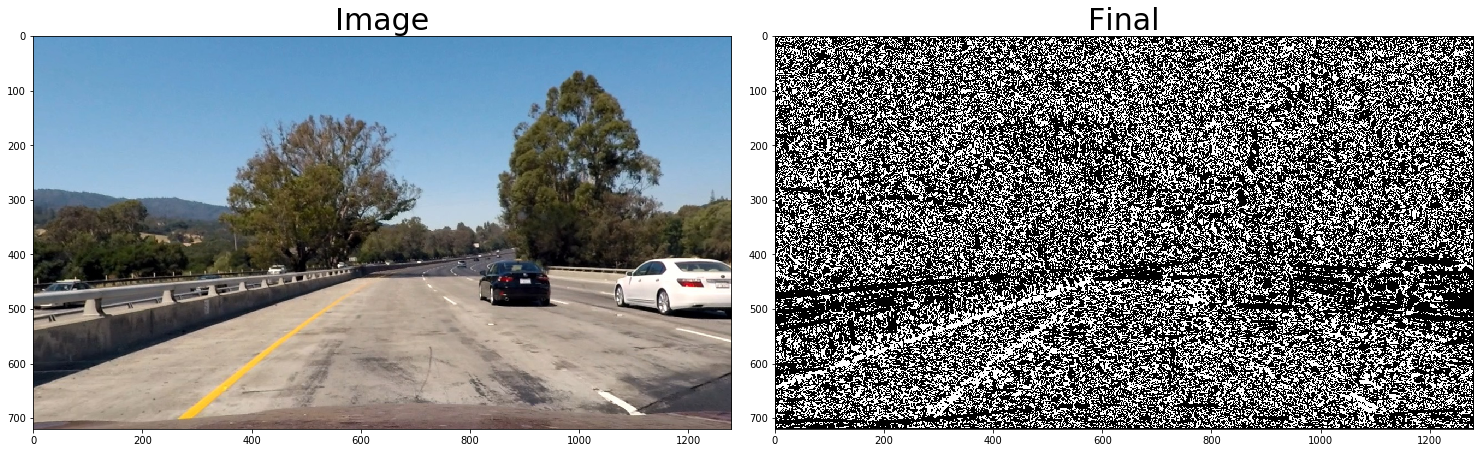

In [11]:
dir_img = dir_threshold(img,sobel_kernel=11)
visualize(img,dir_img)

## Color Thesholding the image
Using the S channel as we have already tested that s channel gives best performance in all the cases

In [12]:
def color_threshold(img, channel='s' ,thresh=(170, 255)):
    """
    Accepts an RGB image and converts it to HLS image and returns a selcted channel-thresholded image
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if channel == 's':
        layer = hls[:,:,2] 
    elif channel == 'h':
        layer = hls[:,:,0]
    elif channel == 'l':
        layer = hls[:,:,1]
    
    binary_output = np.zeros_like(layer)
    binary_output[(layer >= thresh[0]) & (layer <= thresh[1])] = 1

    # Return the binary image
    return binary_output

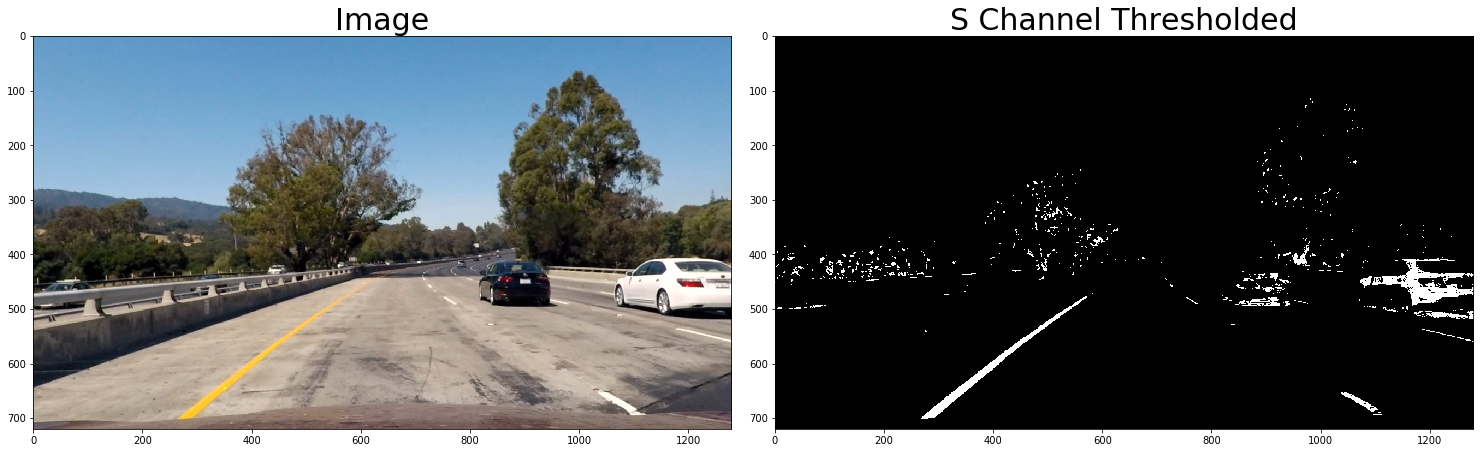

In [13]:
s_channel = color_threshold(img,channel='s')
visualize(img,s_channel,comment2='S Channel Thresholded')

## Combining all the above thresholds to use in lane identification

In [14]:
def Final_threshold(sobel_x, sobel_y, mag_thresh, dir_img, s_channel):
    combined = np.zeros_like(sobel_x)
    combined[((sobel_x == 1) & (sobel_y == 1)) | ((mag_thresh == 1) & (dir_img == 1)) | (s_channel == 1)] = 1
    return combined



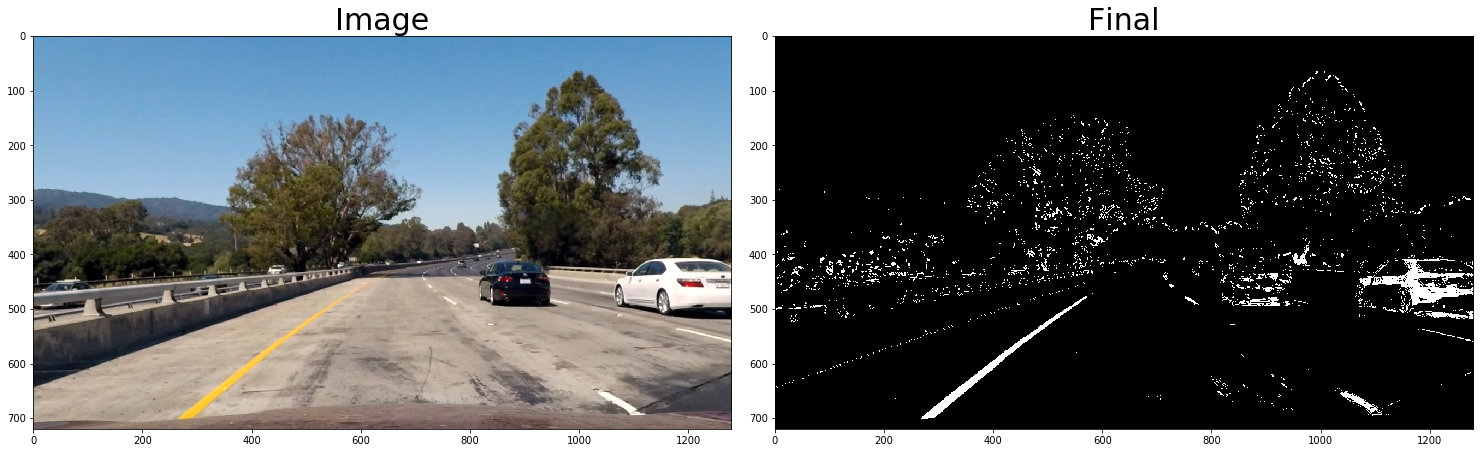

In [15]:
Thresholdedimage = Final_threshold(sobel_x, sobel_y, mag_thresh, dir_img, s_channel)
visualize(img,Thresholdedimage)

## Defining the ROI funtion

In [16]:
def ROI(img, vertices,cvt=False):
    """
    Takes input as RGB image and converts to gray image if cvt is True
    Masks the image outside the vertices region
    """
    #An empty mask
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    
    if cvt == True:
        masked_image = cv2.cvtColor(masked_image,cv2.COLOR_RGB2GRAY)
    return masked_image



In [17]:
imshape = img.shape
left_bottom = (100, imshape[0])
right_bottom = (imshape[1]-20, imshape[0])
apex1 = (610, 410)
apex2 = (680, 410)
inner_left_bottom = (310, imshape[0])
inner_right_bottom = (1000, imshape[0])
inner_apex1 = (700,480)
inner_apex2 = (650,480)
vertices = np.array([[left_bottom, apex1, apex2, right_bottom, inner_right_bottom, \
                      inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)

## Undistorting the image
Load the caliberation parameters from the pickle file if exists or call the function to calculate the parameters

In [18]:
if os.path.isfile("caliberationParameters.pickle") == False:
    images = glob.glob("camera_cal/*.jpg")
    ret, mtx, dist, rvecs, tvecs = caliberate_camera(images)
file = open('caliberationParameters.pickle','rb')
calibparms = pickle.load(file)


### Undistorting the image

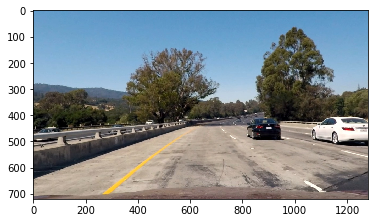

In [19]:
# image = correct_distortion(Thresholdedimage, **calibparms)
# visualize(img, image)
plt.imshow(img)

# Applying perspective transform

#### Using the explanation and quiz in the lessons to create the function

In [47]:
# Define perspective transform function
def warp(img, src_coordinates=None, dst_coordinates=None):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    
    if src_coordinates is None:
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [580,  460],  # Top left
             [700,  460],  # Top right
             [1125, 700]]) # Bottom right
        
    if dst_coordinates is None:
        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)

    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

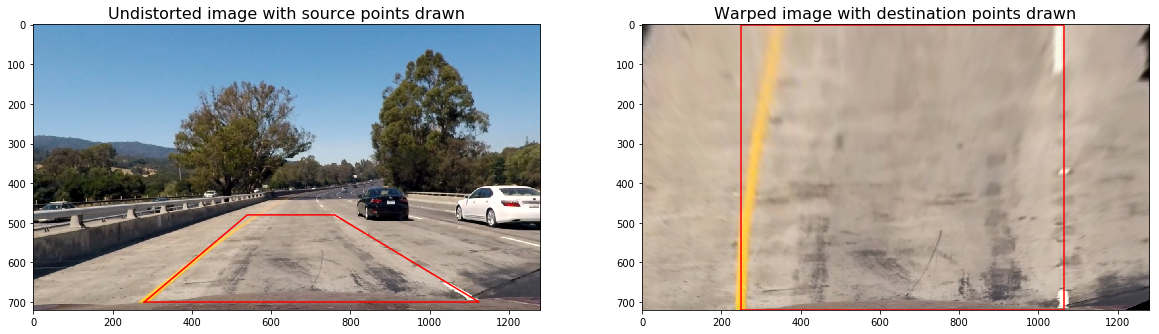

In [48]:
# Run the function
src_coordinates = np.float32(
    [[280,  700],  # Bottom left
     [540,  480],  # Top left
     [760,  480],  # Top right
     [1125, 700]]) # Bottom right


dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right   

warped_img, _ , Minv  = warp(img, src_coordinates, dst_coordinates)

# Visualize undirstorsion
# Notice 'img' was undistorted at the beginning
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src_coordinates).get_xy()[:, 0], Polygon(src_coordinates).get_xy()[:, 1], color='red')
ax1.imshow(img)

ax2.set_title('Warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dst_coordinates).get_xy()[:, 0], Polygon(dst_coordinates).get_xy()[:, 1], color='red')
ax2.imshow(warped_img,cmap='gray')

## Using Sliding window algorithm(histogram)
Using the code from the quiz

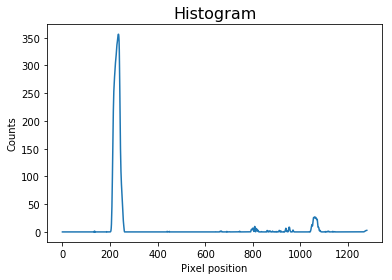

In [22]:
def get_histogram(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)

# Run de function over the combined warped image
combined_warped = warp(Thresholdedimage)[0]
histogram = get_histogram(combined_warped)

# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)

In [23]:
def detect_lines(img, return_img=False):
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(img)

    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)


In [24]:
lines_fit, left_points, right_points, out_img = detect_lines(combined_warped, return_img=True)
# visualize(warped_img, out_img)


In [25]:
def detect_similar_lines(img, line_fits=None, return_img=False):
    if line_fits is None:
        return detect_lines(img, return_img)
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    if return_img:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

In [26]:
lines_fit, left_points, right_points, out_img = detect_similar_lines(combined_warped, lines_fit, return_img=True)

# visualize(warped_img, out_img, comment2='Lane lines detected')

## Measuring the curvature

In [27]:
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [50]:
curvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)


## Calculating the car offset 

In [29]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    
    mid = img_shape[1]//2 # mid point
    car_pos = (leftx[-1] + rightx[-1])/2
    
    offsetx = (mid - car_pos) * xm_per_pix

    return offsetx

In [30]:
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.056137615132 m.


## warping the detected lane boundaries into original image

In [31]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

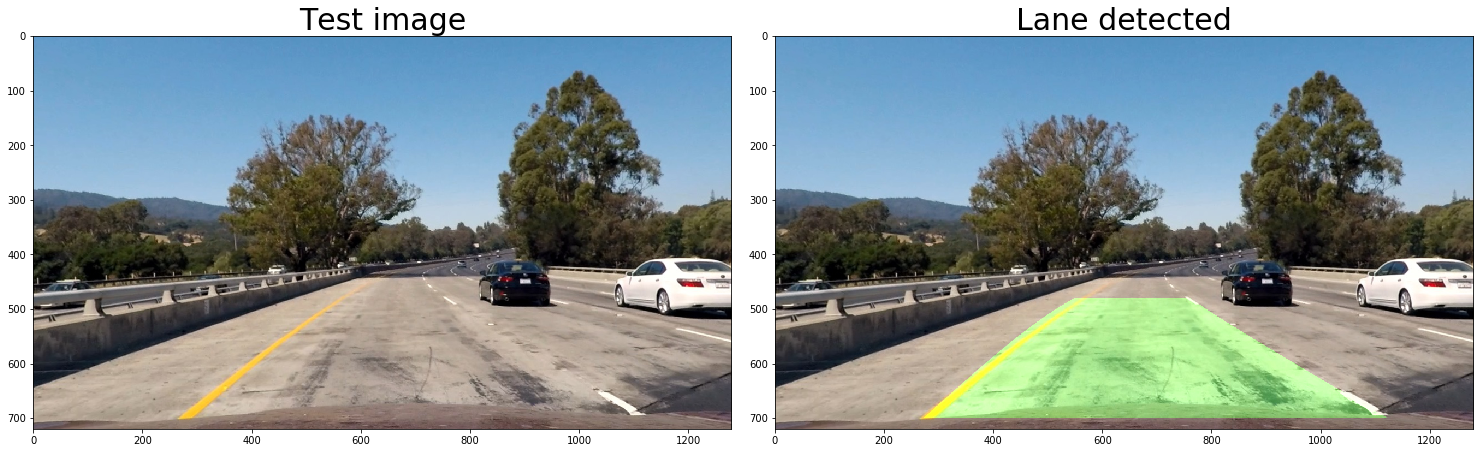

In [32]:
img_lane = draw_lane(img, combined_warped, left_points, right_points, Minv)


visualize(img, comment1='Test image', img2=img_lane, comment2='Lane detected')

## cv2.putText into images

In [33]:
def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Radius of curvature calculation
    curvature_rads = curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # calculating the car postion
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    #writing the same back to image
    out_img = img.copy()
    cv2.putText(out_img, 'Left curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    cv2.putText(out_img, 'car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

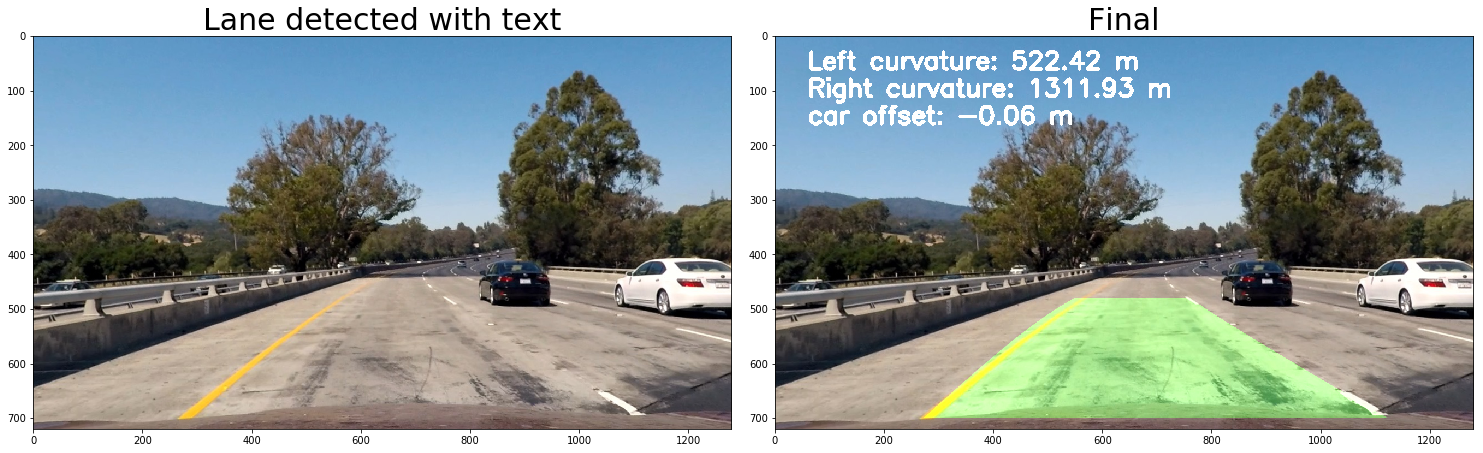

In [34]:
out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
visualize(img,  out_img, 'Lane detected with text')

lines_fit = None

In [43]:
def process_image(img):
#     img = mpimg.imread(img)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = correct_distortion(img, ret, mtx, dist, rvecs, tvecs )
    
    sobel_x = abs_sobel_thresh(img,orient='x')
    sobel_y = abs_sobel_thresh(img,orient='y')
    mag_img = mag_thresh(img)
    dir_img = dir_threshold(img,sobel_kernel=11)
    s_channel = color_threshold(img,channel='s')
    Thresholdedimage = Final_threshold(sobel_x, sobel_y, mag_thresh, dir_img, s_channel)
    warped_img, M , Minv  = warp(Thresholdedimage, src_coordinates, dst_coordinates)
#     lines_fit, left_points, right_points, out_img = detect_lines(warped_img, return_img=True)
    try:
        lines_fit, left_points, right_points, out_img = detect_similar_lines(warped_img, lines_fit, return_img=True)
    except UnboundLocalError:
        lines_fit = None
        lines_fit, left_points, right_points, out_img = detect_similar_lines(warped_img, lines_fit, return_img=True)
    curvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)
    offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)
    img_lane = draw_lane(img, warped_img, left_points, right_points, Minv)
    out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
    return out_img

In [51]:
white_output = 'project_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,20)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4



100%|█████████▉| 1260/1261 [10:35<00:00,  2.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 8min 14s, sys: 2.12 s, total: 8min 17s
Wall time: 10min 38s


In [52]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [40]:
white_output = 'harder_challenge_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,20)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_result.mp4
[MoviePy] Writing video harder_challenge_video_result.mp4



100%|█████████▉| 1199/1200 [11:28<00:00,  1.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_result.mp4 

CPU times: user 8min 6s, sys: 32.6 s, total: 8min 39s
Wall time: 11min 33s


In [41]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(white_output))